In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/488/team/final

Mounted at /content/gdrive
/content/gdrive/MyDrive/488/team/final


## Fine-Tuning Steps

1. **Pre-trained LLM** - [FacebookAI/roberta-large](https://huggingface.co/FacebookAI/roberta-large)
2. **Classification Task** - Multi-Class classification, each instance only belong to one grade, either A, B or C
3. **Dataset** - Use the `listing_id` from Kaggle's [AirBnB Listings & Reviews dataset](https://www.kaggle.com/datasets/mysarahmadbhat/airbnb-listings-reviews/data) to scrape the AirBnB website for the respective listings' reviews. Both training and validation dataset are translated to English language before labelling.
4. **Data Labelling** - Training dataset is labelled by GPT-4 Turbo. Validation dataset is manually labelled by the team, according to this scoring rubrics **insert link to scoring**, majority vote method applies.
5. **Fine-tuning the LLM** - Train the LLM on the training dataset
6. **Evaluate Model Peformance** - Use the validation set to evaluate the model's accuracy, precision, recall and F1-score.


**Link to Final Fine-Tuned Model** : https://huggingface.co/lihuicham/airbnb-reviews-helpfulness-classifier-roberta-base


## 1. Install packages & Import Libraries

In [ ]:
# Install required packages
!pip install transformers[torch]
!pip install accelerate -U
!pip install datasets

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pyparsing/core.py", line 817, in _parseNoCache
    loc, tokens = self.parseImpl(instring, pre_loc, doActions)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pyparsing/core.py", line 2337, in parseImpl
    if instring[loc] == self.firstMatchChar and instring.startswith(
IndexError: string index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packag

In [ ]:
# Import required Packages and Libraries
import pandas as pd
import numpy as np
import random
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import TrainingArguments, Trainer, EvalPrediction, AutoConfig, AutoTokenizer, AutoModelForSequenceClassification, IntervalStrategy
from datasets import Dataset, DatasetDict
from datetime import datetime

## 2. Configure

In [ ]:
# Paths and Filenames
IN_TrainPath = "Data"
IN_TrainSample = "gpt_labelled_reviews"
IN_TestPath = "Data"
IN_TestSample = "manually_labelled_reviews"
Training_Path = "Training"
if not os.path.exists(Training_Path): os.makedirs(Training_Path)

# Set Controls
P = 90   # percentile for max tokens
T = 0.2  # size of test split for training
# -> in our project we have our own test set, which is our 500 manually labelled dataset
seed = 124 # seed used everywhere

# Hugging Face Pre-Trained LLM
pretrained = 'roberta-base'
# try with this smaller model, if it works use roberta-large

In [ ]:
# Use GPU
print(f"PyTorch version: {torch.__version__}")
device = "mps" if "backends" in dir(torch) and hasattr(torch.backends, 'mps') and torch.backends.mps.is_built() and torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu": print("No GPU found, using >>> CPU <<< for training, which will be slow.")
else: print(f"GPU available! Using >>> {device} <<< for training")

PyTorch version: 2.2.1+cu121
GPU available! Using >>> cuda <<< for training


## 3. Helper Functions

In [ ]:
def seed_everything(seed = 124):
    """Seed everything for replicability. Largely works (especially on cuda, but not so much on Apple silicone (mps))"""
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if device == "cuda":
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

def compute_metrics(p):
    # Get the predictions and true labels
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids

    # Calculate the metrics
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='macro')
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

## 4. Load and Prepare Dataset


In [ ]:
TrainSample = pd.read_csv(os.path.join(IN_TrainPath, IN_TrainSample + '.csv'))
TrainSample.index.name = "ID"
TrainSample

,review,label
ID,,
0,I would give Ugo stars if I could His apartmen...,B
1,Alexandra has a nice apartment Even with a sma...,B
2,Lovely little apartment in a great location in...,B
3,Roman was a fantastic host The apartment was p...,A
4,My husband and I LOVED our stay at Simon s pla...,A
...,...,...
4555,Amazing place good location very confortable a...,B
4556,Das Zimmer war wie in der Anzeige beschrieben ...,A
4557,Gabriel s place is great It s so comfortable I...,B


In [ ]:
TestSample = pd.read_csv(os.path.join(IN_TestPath, IN_TestSample + '.csv'))
TestSample = TestSample.drop(columns=['listing_id'])
TestSample.index.name = "ID"
TestSample

,review,label
ID,,
0,"We had a great weekend in Pauline's apartment,...",B
1,Very good stay with Sylvain.Impeccable and ver...,C
2,Perfect Paris apartment! The location is great...,B
3,"Amazing. Close to metro, fun area of the city....",C
4,This was a favourite stay for us. Marietta wai...,A
...,...,...
495,What an incredible experience in Paris! Lauren...,B
496,Apartment as ad.A pleasant stay in Marine's ap...,B
497,"Perfect stay, the apartment is very beautiful,...",B


In [ ]:
label_counts = TrainSample['label'].value_counts()
print(label_counts)


label
B    2630
C    1028
A     902
Name: count, dtype: int64


In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
TrainSample2 = TrainSample.copy()
TrainSample2['label'].value_counts()

label
B    2630
C    1028
A     902
Name: count, dtype: int64

In [ ]:
features2 = TrainSample2.drop('label', axis=1)  # or another way to get your feature columns
labels2 = TrainSample2['label']

ros = RandomOverSampler(random_state=42)

features_resampled, labels_resampled = ros.fit_resample(features2, labels2)

# Create a DataFrame of the resampled data
TrainSample_resampled = pd.DataFrame(features_resampled, columns=features2.columns)
TrainSample_resampled['label'] = labels_resampled

# If you need to reset the index to match the original:
TrainSample_resampled.index.name = "ID"


In [ ]:
TrainSample_resampled['label'].value_counts()

label
B    2630
A    2630
C    2630
Name: count, dtype: int64

In [ ]:
label_counts = TestSample['label'].value_counts()
print(label_counts)


label
B    228
C    208
A     64
Name: count, dtype: int64


In [ ]:
# Create HuggingFace Dataset
dataset = DatasetDict({"train":Dataset.from_dict(TrainSample_resampled),"test":Dataset.from_dict(TestSample)})

# Create an id2label mapping
labels = sorted(set(dataset["train"]["label"]))

id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

In [ ]:
labels

['A', 'B', 'C']

In [ ]:
id2label

{0: 'A', 1: 'B', 2: 'C'}

In [ ]:
label_encoder = LabelEncoder()
all_labels = [example["label"] for example in dataset["train"]]
label_encoder.fit(all_labels)

def preprocess(examples):
    text = examples["review"]
    # Convert labels to integers using label encoder
    labels = label_encoder.transform(examples["label"])
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
    encoding['labels'] = labels
    return encoding

## 5. Tokenize

In [ ]:
# Set Tokenizer
tokenizer = AutoTokenizer.from_pretrained(pretrained)

# Prohibit Paralell Tokenization (can lead to forking in loops and batch processing)
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Create encoded dataset
# Ensure 'remove_columns' is targeting the correct part of the dataset
encoded_dataset = dataset.map(preprocess, batched=True, remove_columns=dataset['train'].column_names)

# Set encoded dataset to pytorch tensors
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/7890 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

## 6. Set-up Fine-Tuning of LLM

In [ ]:
# Set basic Hyperparameters for training
hyperparameters =  {'learning_rate': 3e-05,
                    'per_device_train_batch_size': 16,
                    'weight_decay': 1e-04,
                    'num_train_epochs': 4,
                    'warmup_steps': 500}

In [ ]:
# Seed Torch etc.
seed_everything(seed)

# Instantiate Classifier
model = AutoModelForSequenceClassification.from_pretrained(pretrained,
                                                         num_labels=len(labels),
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model.config)

RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "A",
    "1": "B",
    "2": "C"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "A": 0,
    "B": 1,
    "C": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.40.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



In [ ]:
# Set Training Arguments
training_args = TrainingArguments(
    output_dir=f"{Training_Path}",
    evaluation_strategy="epoch",
    logging_dir=f"{Training_Path}/Logs",
    logging_strategy="steps",
    logging_steps=10,
    per_device_train_batch_size=hyperparameters['per_device_train_batch_size'],
    per_device_eval_batch_size= hyperparameters['per_device_train_batch_size'],
    num_train_epochs=hyperparameters['num_train_epochs'],
    learning_rate=hyperparameters['learning_rate'],
    weight_decay=hyperparameters['weight_decay'],
    warmup_steps=hyperparameters['warmup_steps'],
    save_strategy="epoch",
    load_best_model_at_end=True,
    save_total_limit=2,
    use_mps_device=(device == "mps"),
    optim='adamw_torch',
    seed=seed
)

# Instantiate Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
print("Ready to Create Synthetic Expert")

Ready to Create Synthetic Expert


## 7. Fine-Tune and Evaluate

In [ ]:
# Fine-tune the model with trainer to create Synthetic Expert
print(f"Started training with seed {seed} at {datetime.now()}\nFine-tuning {pretrained}")
trainer.train()
print(f"Completed training at {datetime.now()}")

Started training with seed 124 at 2024-04-28 22:13:08.520344
Fine-tuning roberta-base


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.533900,1.249057,0.502000,0.497464,0.574362,0.562057
2,0.409200,0.980797,0.646000,0.589772,0.618288,0.579988
3,0.166500,1.759467,0.618000,0.569187,0.654116,0.569163
4,0.147100,2.322143,0.602000,0.551476,0.619609,0.550396


Completed training at 2024-04-28 22:39:48.154152


In [ ]:
# Evaluate Synthetic Expert on test data
print("Model performance on Test")
trainer.evaluate()

Model performance on Test


{'eval_loss': 0.9807973504066467,
 'eval_accuracy': 0.646,
 'eval_f1': 0.5897724270142485,
 'eval_precision': 0.6182881917501138,
 'eval_recall': 0.5799876293297347,
 'eval_runtime': 8.2884,
 'eval_samples_per_second': 60.325,
 'eval_steps_per_second': 3.861,
 'epoch': 4.0}

In [ ]:
#  Evaluate Synthetic Expert on train data
print("Model performance on Train")
trainer.eval_dataset = encoded_dataset["train"]
trainer.evaluate()

Model performance on Train


{'eval_loss': 0.21534372866153717,
 'eval_accuracy': 0.9219264892268695,
 'eval_f1': 0.9213405328514277,
 'eval_precision': 0.921928777777207,
 'eval_recall': 0.9219264892268694,
 'eval_runtime': 131.009,
 'eval_samples_per_second': 60.225,
 'eval_steps_per_second': 3.771,
 'epoch': 4.0}

In [ ]:
# Obtain predictions
predictions = trainer.predict(encoded_dataset["test"])
# Get the predicted labels
pred_labels = np.argmax(predictions.predictions, axis=1)

# Extract the true labels
true_labels = predictions.label_ids

# Extract the reviews (assuming they have been tokenized and are available as input_ids)
reviews = encoded_dataset["test"]["input_ids"]

# Decode the reviews back to text if they are in tokenized form
decoded_reviews = [tokenizer.decode(ids, skip_special_tokens=True) for ids in reviews]

# Create a DataFrame
import pandas as pd

df = pd.DataFrame({
    'review': decoded_reviews,
    'predicted_label': [id2label[pred] for pred in pred_labels],  # Use id2label to convert to label names
    'true_label': [id2label[true] for true in true_labels]  # Use id2label to convert to label names
})

# Now you can print the DataFrame
print(df)


                                                review predicted_label  \
0    We had a great weekend in Pauline's apartment,...               B   
1    Very good stay with Sylvain.Impeccable and ver...               C   
2    Perfect Paris apartment! The location is great...               C   
3    Amazing. Close to metro, fun area of the city....               C   
4    This was a favourite stay for us. Marietta wai...               B   
..                                                 ...             ...   
495  What an incredible experience in Paris! Lauren...               B   
496  Apartment as ad.A pleasant stay in Marine's ap...               B   
497  Perfect stay, the apartment is very beautiful,...               B   
498  The impeccable state and the quality of recept...               C   
499  I highly recommend this flat. Amazing location...               B   

    true_label  
0            B  
1            C  
2            B  
3            C  
4            A  
..       

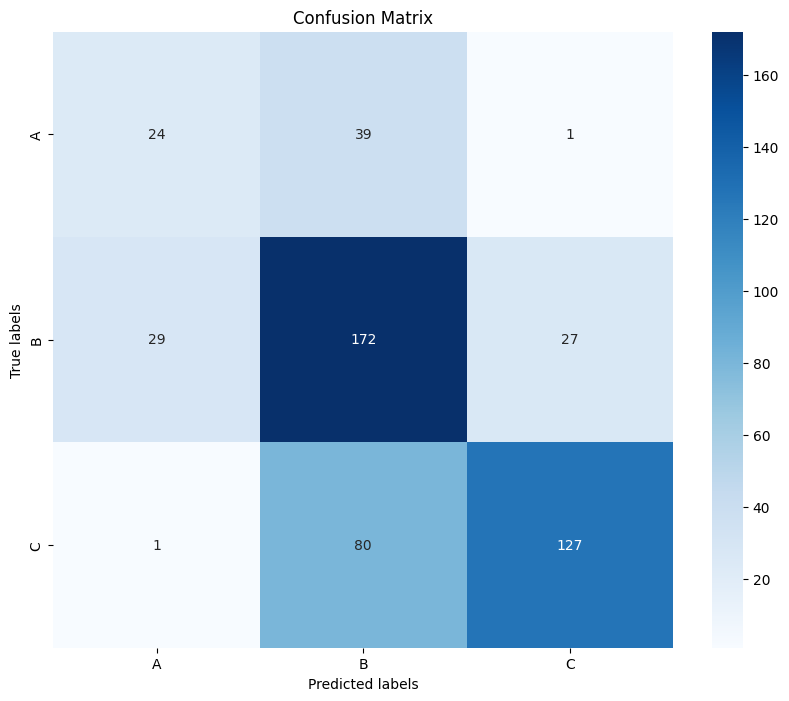

In [ ]:
# Obtain predictions and true labels
predictions = trainer.predict(encoded_dataset["test"])
preds = np.argmax(predictions.predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(predictions.label_ids, preds)

# Plotting the confusion matrix with seaborn
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=list(id2label.values()), yticklabels=list(id2label.values()))
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 8. Save & Upload Fine-Tuned Model to Hugging Face

Follow this hugging face [documentation](https://huggingface.co/docs/transformers/v4.15.0/en/model_sharing#basic-steps) > Workflow in a Colab notebook to upload the fine-tuned model to your repository.

The upload code is removed to protect the access token.

Link to Hugging Face model : https://huggingface.co/lihuicham/airbnb-reviews-helpfulness-classifier-roberta-base


In [ ]:
# Save fine-tuned model
# trainer.save_model(f"{Any_Path}/airbnb-reviews-helpfulness-classifier-roberta-base")